В прошлых версиях (см ноутбуки ```circle_diagram_FAST_TEST.ipynb```, ```circle_diagram_FAST_TEST_ANOTHER_POINT.ipynb```) в качестве диаграммы агента использовалась полноценная диаграмма, построенная на полных данных. Понятно, что в реальности агенту не может быть доступно столько информации, поэтому, чтобы сделать диаграмму более реалистичной, уменьшим каждый сектор - пусть в нём будет информация только о нескольких ближайших объектах.

In [25]:
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2

from openstreetmap_load_data import find_objects_bounds, load_data_from_openstreetmap
from utils import calculate_right_top_coordinates
from google_api_load_data import load_prepare_and_cut_image
from osm_object import One_OSM_object, Image_OSM_object

from circle_diagram import Image_circle_diagrams, Agent_circle_diagram
from circle_diagram import calculate_sectors_count, create_circle_diagram
from circle_diagram import select_minimum_penalty_element_grid


In [2]:
def load_all_image_info(left_bottom_lat, left_bottom_lon, data_path, image_path, load_from_net=False):
    right_top_lat, right_top_lon = calculate_right_top_coordinates(left_bottom_lat, left_bottom_lon)
    
    if load_from_net:
        load_data_from_openstreetmap(left_bottom_lat, left_bottom_lon, right_top_lat, right_top_lon, data_path)
        img_cutted_satellite = load_prepare_and_cut_image(left_bottom_lat=left_bottom_lat, left_bottom_lon=left_bottom_lon,
                                                      right_top_lat=right_top_lat, right_top_lon=right_top_lon,
                                                      is_debug=False)
        cv2.imwrite(image_path, img_cutted_satellite)
        
    bounds, tags = find_objects_bounds(data_path, right_top_lat, right_top_lon, left_bottom_lat, left_bottom_lon)
    
    img_cutted_satellite = cv2.imread(image_path)
    
    return img_cutted_satellite, bounds, tags, right_top_lat, right_top_lon

In [3]:
left_bottom_lat = 54.3
left_bottom_lon = 48.6

img_cutted_satellite, bounds, tags, right_top_lat, right_top_lon = load_all_image_info(
    left_bottom_lat=left_bottom_lat, left_bottom_lon=left_bottom_lon,
    data_path="jsons/42.json", image_path="images/42.png")

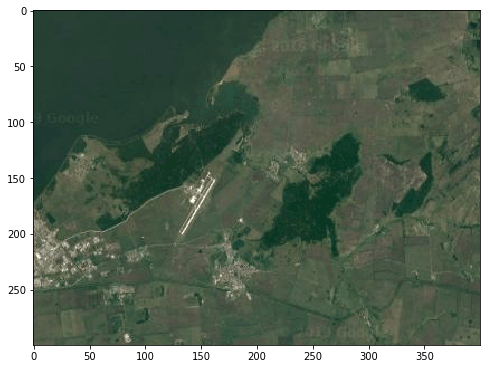

In [4]:
plt.figure(figsize=(8, 10))
plt.imshow(cv2.cvtColor(img_cutted_satellite, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
img_osm = Image_OSM_object(
    img_cutted_satellite.shape,
    right_top_lat,
    right_top_lon,
    left_bottom_lat,
    left_bottom_lon,
    bounds,
    tags
)


In [10]:
bigger_side_blocks_count = 8
sectors_count = calculate_sectors_count(bigger_side_blocks_count)

img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)

In [62]:
agent_point = (226, 324)
agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm)

In [63]:
agent_cd.make_fast()

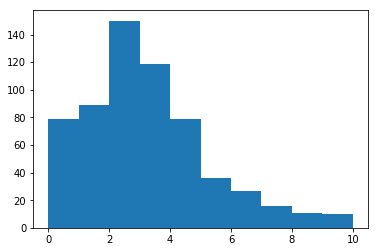

In [57]:
original_sectors_lengths = [len(sector) for sector in agent_cd.sectors]
plt.hist(original_sectors_lengths)
plt.show()

### Используем все объекты

In [64]:
%%time
center_points_minimum_penalty, indices_minimum_penalty, penalties = select_minimum_penalty_element_grid(img_cds,
                                                                                                        agent_cd,
                                                                                            use_fast=True)
print(center_points_minimum_penalty)
print(indices_minimum_penalty)

[(225.0, 325.0)]
[38]
CPU times: user 372 ms, sys: 0 ns, total: 372 ms
Wall time: 372 ms


50.0
25.0
(6, 8)


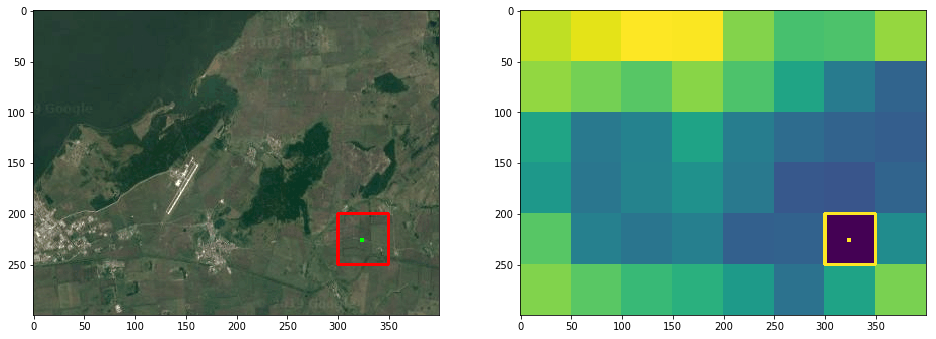

In [65]:
bigger_side = max(img_cutted_satellite.shape[0], img_cutted_satellite.shape[1])
one_block_len = bigger_side / bigger_side_blocks_count
print(one_block_len)
half = one_block_len / 2
print(half)

penalties_reshaped = np.array(penalties).reshape(int(len(penalties) / bigger_side_blocks_count),
                                                         bigger_side_blocks_count)
print(penalties_reshaped.shape)

img_result_show = img_cutted_satellite.copy()

for center_point in center_points_minimum_penalty:
    cv2.rectangle(img_result_show,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
img_result_show[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [[0, 255, 0] for _ in range(4)]

plt.figure(figsize=(16, 20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.subplot(122)

penalties_img = np.repeat(np.repeat(penalties_reshaped,
                                    one_block_len
                                    , axis=0),
                          one_block_len,
                          axis=1).reshape(img_result_show.shape[:2])
points_color = np.max(penalties)
for center_point in center_points_minimum_penalty:
    cv2.rectangle(penalties_img,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), points_color, 2)
penalties_img[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [points_color for _ in range(4)]
plt.imshow(penalties_img)

plt.show()

### Используем только 3 ближайших объекта

In [51]:
def cut_sectors(circle_diagram, max_len):
    for i in range(len(circle_diagram.sectors)):
        circle_diagram.sectors[i] = circle_diagram.sectors[i][:max_len]
    return circle_diagram

In [58]:
agent_cd = cut_sectors(agent_cd, max_len=3)

In [59]:
agent_cd.make_fast()

In [60]:
%%time
center_points_minimum_penalty, indices_minimum_penalty, penalties = select_minimum_penalty_element_grid(img_cds,
                                                                                                        agent_cd,
                                                                                            use_fast=True)
print(center_points_minimum_penalty)
print(indices_minimum_penalty)

[(225.0, 325.0)]
[38]
CPU times: user 332 ms, sys: 0 ns, total: 332 ms
Wall time: 329 ms


50.0
25.0
(6, 8)


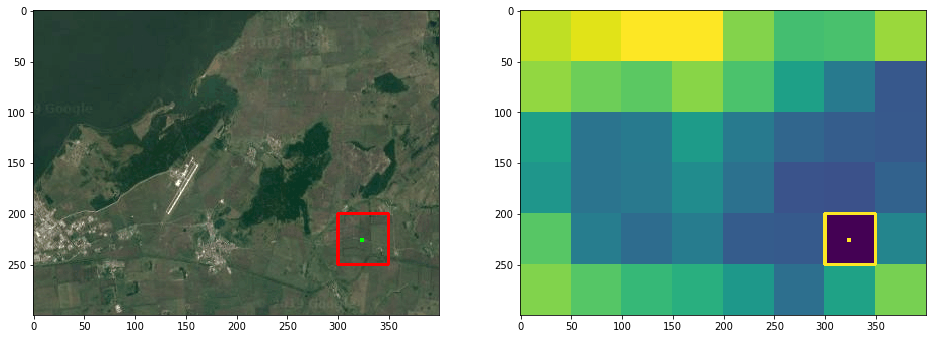

In [61]:
bigger_side = max(img_cutted_satellite.shape[0], img_cutted_satellite.shape[1])
one_block_len = bigger_side / bigger_side_blocks_count
print(one_block_len)
half = one_block_len / 2
print(half)

penalties_reshaped = np.array(penalties).reshape(int(len(penalties) / bigger_side_blocks_count),
                                                         bigger_side_blocks_count)
print(penalties_reshaped.shape)

img_result_show = img_cutted_satellite.copy()

for center_point in center_points_minimum_penalty:
    cv2.rectangle(img_result_show,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
img_result_show[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [[0, 255, 0] for _ in range(4)]

plt.figure(figsize=(16, 20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.subplot(122)

penalties_img = np.repeat(np.repeat(penalties_reshaped,
                                    one_block_len
                                    , axis=0),
                          one_block_len,
                          axis=1).reshape(img_result_show.shape[:2])
points_color = np.max(penalties)
for center_point in center_points_minimum_penalty:
    cv2.rectangle(penalties_img,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), points_color, 2)
penalties_img[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [points_color for _ in range(4)]
plt.imshow(penalties_img)

plt.show()

### Используем только 2 ближайших объекта

In [66]:
agent_cd = cut_sectors(agent_cd, max_len=2)
agent_cd.make_fast()

In [67]:
%%time
center_points_minimum_penalty, indices_minimum_penalty, penalties = select_minimum_penalty_element_grid(img_cds,
                                                                                                        agent_cd,
                                                                                            use_fast=True)
print(center_points_minimum_penalty)
print(indices_minimum_penalty)

[(225.0, 325.0)]
[38]
CPU times: user 284 ms, sys: 0 ns, total: 284 ms
Wall time: 286 ms


50.0
25.0
(6, 8)


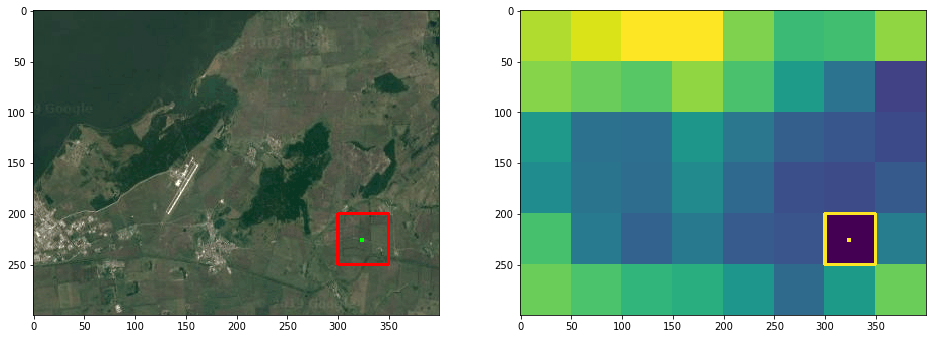

In [68]:
bigger_side = max(img_cutted_satellite.shape[0], img_cutted_satellite.shape[1])
one_block_len = bigger_side / bigger_side_blocks_count
print(one_block_len)
half = one_block_len / 2
print(half)

penalties_reshaped = np.array(penalties).reshape(int(len(penalties) / bigger_side_blocks_count),
                                                         bigger_side_blocks_count)
print(penalties_reshaped.shape)

img_result_show = img_cutted_satellite.copy()

for center_point in center_points_minimum_penalty:
    cv2.rectangle(img_result_show,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
img_result_show[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [[0, 255, 0] for _ in range(4)]

plt.figure(figsize=(16, 20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.subplot(122)

penalties_img = np.repeat(np.repeat(penalties_reshaped,
                                    one_block_len
                                    , axis=0),
                          one_block_len,
                          axis=1).reshape(img_result_show.shape[:2])
points_color = np.max(penalties)
for center_point in center_points_minimum_penalty:
    cv2.rectangle(penalties_img,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), points_color, 2)
penalties_img[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [points_color for _ in range(4)]
plt.imshow(penalties_img)

plt.show()

### Используем только 1 ближайший объект

In [69]:
agent_cd = cut_sectors(agent_cd, max_len=1)
agent_cd.make_fast()

In [72]:
%%time
center_points_minimum_penalty, indices_minimum_penalty, penalties = select_minimum_penalty_element_grid(img_cds,
                                                                                                        agent_cd,
                                                                                            use_fast=True)
print(center_points_minimum_penalty)
print(indices_minimum_penalty)

[(225.0, 325.0)]
[38]
CPU times: user 276 ms, sys: 0 ns, total: 276 ms
Wall time: 275 ms


50.0
25.0
(6, 8)


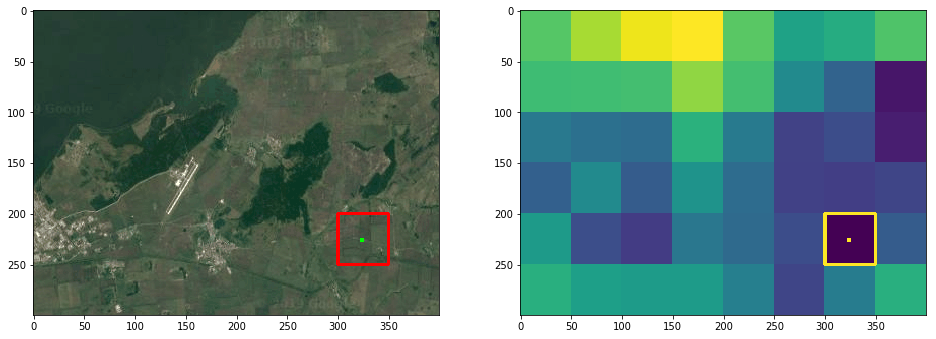

In [73]:
bigger_side = max(img_cutted_satellite.shape[0], img_cutted_satellite.shape[1])
one_block_len = bigger_side / bigger_side_blocks_count
print(one_block_len)
half = one_block_len / 2
print(half)

penalties_reshaped = np.array(penalties).reshape(int(len(penalties) / bigger_side_blocks_count),
                                                         bigger_side_blocks_count)
print(penalties_reshaped.shape)

img_result_show = img_cutted_satellite.copy()

for center_point in center_points_minimum_penalty:
    cv2.rectangle(img_result_show,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
img_result_show[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [[0, 255, 0] for _ in range(4)]

plt.figure(figsize=(16, 20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.subplot(122)

penalties_img = np.repeat(np.repeat(penalties_reshaped,
                                    one_block_len
                                    , axis=0),
                          one_block_len,
                          axis=1).reshape(img_result_show.shape[:2])
points_color = np.max(penalties)
for center_point in center_points_minimum_penalty:
    cv2.rectangle(penalties_img,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), points_color, 2)
penalties_img[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [points_color for _ in range(4)]
plt.imshow(penalties_img)

plt.show()

Здесь как-то улучшения особенно не заметны, попробуем рассматреть случай, где изначально всё было хуже

**Полная диаграмма**

In [74]:
agent_point = (120, 120)
agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm)
agent_cd.make_fast()

In [75]:
%%time
center_points_minimum_penalty, indices_minimum_penalty, penalties = select_minimum_penalty_element_grid(img_cds,
                                                                                                        agent_cd,
                                                                                            use_fast=True)
print(center_points_minimum_penalty)
print(indices_minimum_penalty)

[(125.0, 175.0)]
[19]
CPU times: user 404 ms, sys: 0 ns, total: 404 ms
Wall time: 405 ms


50.0
25.0
(6, 8)


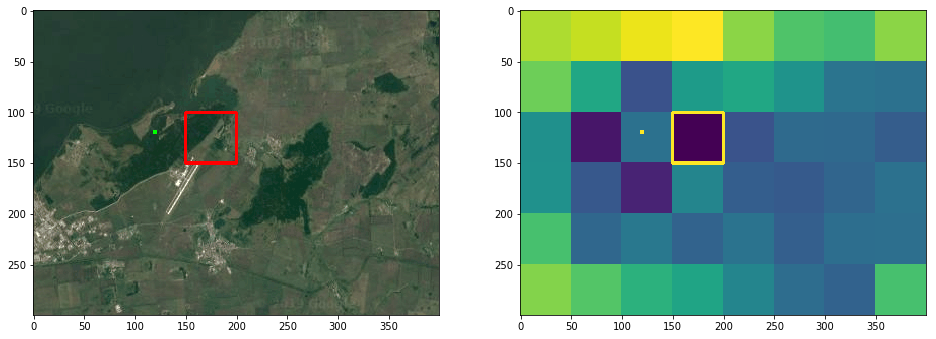

In [76]:
bigger_side = max(img_cutted_satellite.shape[0], img_cutted_satellite.shape[1])
one_block_len = bigger_side / bigger_side_blocks_count
print(one_block_len)
half = one_block_len / 2
print(half)

penalties_reshaped = np.array(penalties).reshape(int(len(penalties) / bigger_side_blocks_count),
                                                         bigger_side_blocks_count)
print(penalties_reshaped.shape)

img_result_show = img_cutted_satellite.copy()

for center_point in center_points_minimum_penalty:
    cv2.rectangle(img_result_show,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
img_result_show[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [[0, 255, 0] for _ in range(4)]

plt.figure(figsize=(16, 20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.subplot(122)

penalties_img = np.repeat(np.repeat(penalties_reshaped,
                                    one_block_len
                                    , axis=0),
                          one_block_len,
                          axis=1).reshape(img_result_show.shape[:2])
points_color = np.max(penalties)
for center_point in center_points_minimum_penalty:
    cv2.rectangle(penalties_img,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), points_color, 2)
penalties_img[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [points_color for _ in range(4)]
plt.imshow(penalties_img)

plt.show()

**Используем только 3 ближайших объекта**

In [77]:
agent_cd = cut_sectors(agent_cd, max_len=3)
agent_cd.make_fast()

In [78]:
%%time
center_points_minimum_penalty, indices_minimum_penalty, penalties = select_minimum_penalty_element_grid(img_cds,
                                                                                                        agent_cd,
                                                                                            use_fast=True)
print(center_points_minimum_penalty)
print(indices_minimum_penalty)

[(125.0, 175.0)]
[19]
CPU times: user 300 ms, sys: 0 ns, total: 300 ms
Wall time: 299 ms


50.0
25.0
(6, 8)


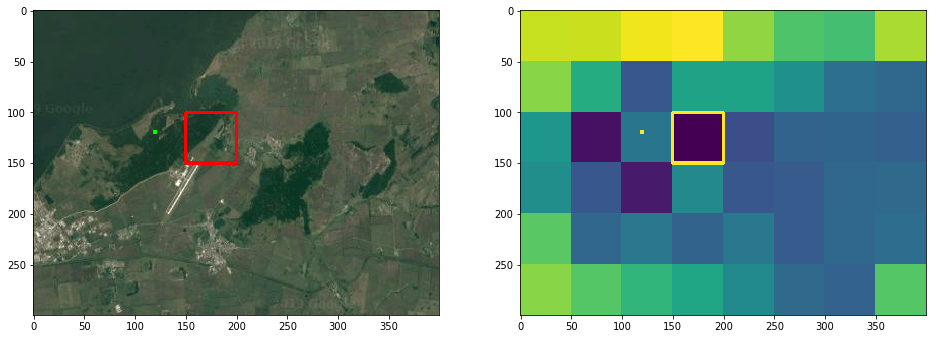

In [79]:
bigger_side = max(img_cutted_satellite.shape[0], img_cutted_satellite.shape[1])
one_block_len = bigger_side / bigger_side_blocks_count
print(one_block_len)
half = one_block_len / 2
print(half)

penalties_reshaped = np.array(penalties).reshape(int(len(penalties) / bigger_side_blocks_count),
                                                         bigger_side_blocks_count)
print(penalties_reshaped.shape)

img_result_show = img_cutted_satellite.copy()

for center_point in center_points_minimum_penalty:
    cv2.rectangle(img_result_show,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
img_result_show[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [[0, 255, 0] for _ in range(4)]

plt.figure(figsize=(16, 20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.subplot(122)

penalties_img = np.repeat(np.repeat(penalties_reshaped,
                                    one_block_len
                                    , axis=0),
                          one_block_len,
                          axis=1).reshape(img_result_show.shape[:2])
points_color = np.max(penalties)
for center_point in center_points_minimum_penalty:
    cv2.rectangle(penalties_img,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), points_color, 2)
penalties_img[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [points_color for _ in range(4)]
plt.imshow(penalties_img)

plt.show()

**Используем только 2 ближайших объекта**

In [80]:
agent_cd = cut_sectors(agent_cd, max_len=2)
agent_cd.make_fast()

In [81]:
%%time
center_points_minimum_penalty, indices_minimum_penalty, penalties = select_minimum_penalty_element_grid(img_cds,
                                                                                                        agent_cd,
                                                                                            use_fast=True)
print(center_points_minimum_penalty)
print(indices_minimum_penalty)

[(125.0, 175.0)]
[19]
CPU times: user 284 ms, sys: 0 ns, total: 284 ms
Wall time: 287 ms


50.0
25.0
(6, 8)


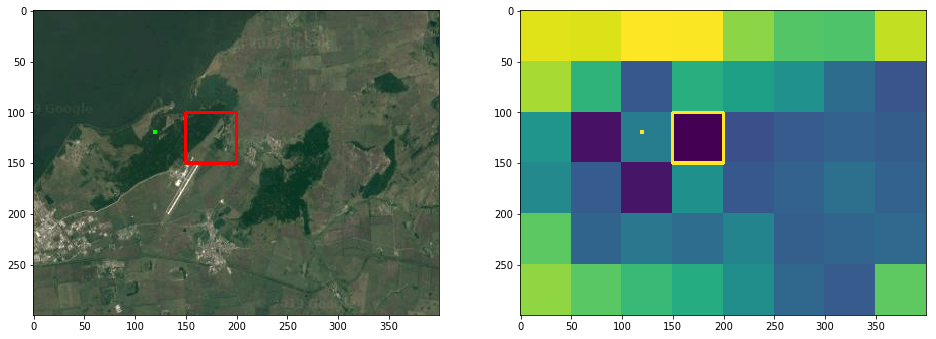

In [82]:
bigger_side = max(img_cutted_satellite.shape[0], img_cutted_satellite.shape[1])
one_block_len = bigger_side / bigger_side_blocks_count
print(one_block_len)
half = one_block_len / 2
print(half)

penalties_reshaped = np.array(penalties).reshape(int(len(penalties) / bigger_side_blocks_count),
                                                         bigger_side_blocks_count)
print(penalties_reshaped.shape)

img_result_show = img_cutted_satellite.copy()

for center_point in center_points_minimum_penalty:
    cv2.rectangle(img_result_show,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
img_result_show[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [[0, 255, 0] for _ in range(4)]

plt.figure(figsize=(16, 20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.subplot(122)

penalties_img = np.repeat(np.repeat(penalties_reshaped,
                                    one_block_len
                                    , axis=0),
                          one_block_len,
                          axis=1).reshape(img_result_show.shape[:2])
points_color = np.max(penalties)
for center_point in center_points_minimum_penalty:
    cv2.rectangle(penalties_img,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), points_color, 2)
penalties_img[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [points_color for _ in range(4)]
plt.imshow(penalties_img)

plt.show()

**Используем только 1 ближайший объект**

In [83]:
agent_cd = cut_sectors(agent_cd, max_len=1)
agent_cd.make_fast()

In [84]:
%%time
center_points_minimum_penalty, indices_minimum_penalty, penalties = select_minimum_penalty_element_grid(img_cds,
                                                                                                        agent_cd,
                                                                                            use_fast=True)
print(center_points_minimum_penalty)
print(indices_minimum_penalty)

[(125.0, 175.0)]
[19]
CPU times: user 276 ms, sys: 0 ns, total: 276 ms
Wall time: 277 ms


50.0
25.0
(6, 8)


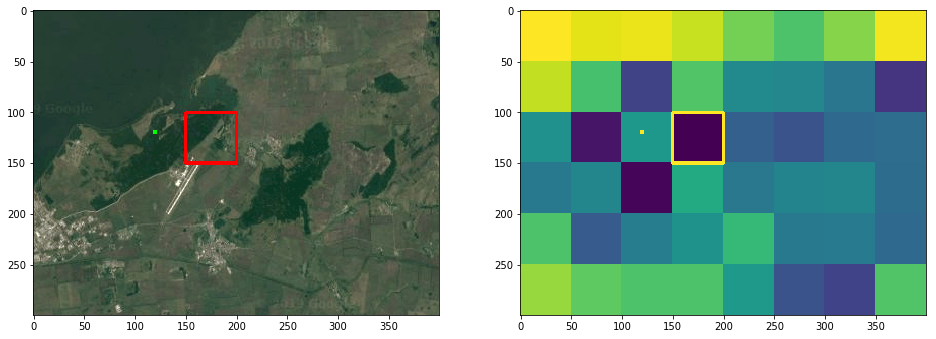

In [85]:
bigger_side = max(img_cutted_satellite.shape[0], img_cutted_satellite.shape[1])
one_block_len = bigger_side / bigger_side_blocks_count
print(one_block_len)
half = one_block_len / 2
print(half)

penalties_reshaped = np.array(penalties).reshape(int(len(penalties) / bigger_side_blocks_count),
                                                         bigger_side_blocks_count)
print(penalties_reshaped.shape)

img_result_show = img_cutted_satellite.copy()

for center_point in center_points_minimum_penalty:
    cv2.rectangle(img_result_show,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
img_result_show[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [[0, 255, 0] for _ in range(4)]

plt.figure(figsize=(16, 20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.subplot(122)

penalties_img = np.repeat(np.repeat(penalties_reshaped,
                                    one_block_len
                                    , axis=0),
                          one_block_len,
                          axis=1).reshape(img_result_show.shape[:2])
points_color = np.max(penalties)
for center_point in center_points_minimum_penalty:
    cv2.rectangle(penalties_img,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), points_color, 2)
penalties_img[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [points_color for _ in range(4)]
plt.imshow(penalties_img)

plt.show()

Здесь тоже как-то не особенно помогло, а что если рассмотреть более мелкое разбиение?

In [86]:
bigger_side_blocks_count = 20
sectors_count = calculate_sectors_count(bigger_side_blocks_count)

img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)

/media/ura/Windows/Users/ura-lenovo/ubuntu_mount/Diploma/utils.py:38: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(scalar_product / (norm_1 * norm_2)))


In [90]:
agent_point = (120, 120)
agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm)

In [91]:
agent_cd.make_fast()

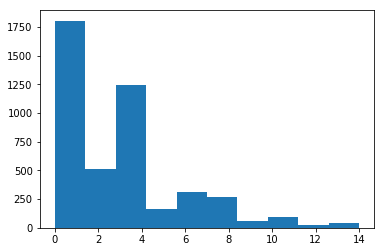

In [92]:
original_sectors_lengths = [len(sector) for sector in agent_cd.sectors]
plt.hist(original_sectors_lengths)
plt.show()

**Оригинальная диаграмма**

In [93]:
%%time
center_points_minimum_penalty, indices_minimum_penalty, penalties = select_minimum_penalty_element_grid(img_cds,
                                                                                                        agent_cd,
                                                                                            use_fast=True)
print(center_points_minimum_penalty)
print(indices_minimum_penalty)

[(150.0, 130.0)]
[146]
CPU times: user 1min 50s, sys: 0 ns, total: 1min 50s
Wall time: 1min 50s


20.0
10.0
(15, 20)


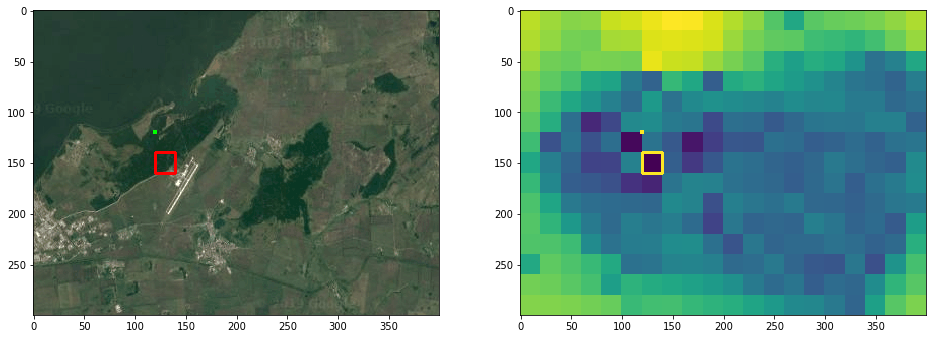

In [94]:
bigger_side = max(img_cutted_satellite.shape[0], img_cutted_satellite.shape[1])
one_block_len = bigger_side / bigger_side_blocks_count
print(one_block_len)
half = one_block_len / 2
print(half)

penalties_reshaped = np.array(penalties).reshape(int(len(penalties) / bigger_side_blocks_count),
                                                         bigger_side_blocks_count)
print(penalties_reshaped.shape)

img_result_show = img_cutted_satellite.copy()

for center_point in center_points_minimum_penalty:
    cv2.rectangle(img_result_show,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
img_result_show[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [[0, 255, 0] for _ in range(4)]

plt.figure(figsize=(16, 20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.subplot(122)

penalties_img = np.repeat(np.repeat(penalties_reshaped,
                                    one_block_len
                                    , axis=0),
                          one_block_len,
                          axis=1).reshape(img_result_show.shape[:2])
points_color = np.max(penalties)
for center_point in center_points_minimum_penalty:
    cv2.rectangle(penalties_img,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), points_color, 2)
penalties_img[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [points_color for _ in range(4)]
plt.imshow(penalties_img)

plt.show()

**Используем только 3 ближайших объекта**

In [95]:
agent_cd = cut_sectors(agent_cd, max_len=3)
agent_cd.make_fast()

In [96]:
%%time
center_points_minimum_penalty, indices_minimum_penalty, penalties = select_minimum_penalty_element_grid(img_cds,
                                                                                                        agent_cd,
                                                                                            use_fast=True)
print(center_points_minimum_penalty)
print(indices_minimum_penalty)

[(150.0, 130.0)]
[146]
CPU times: user 1min 32s, sys: 0 ns, total: 1min 32s
Wall time: 1min 32s


20.0
10.0
(15, 20)


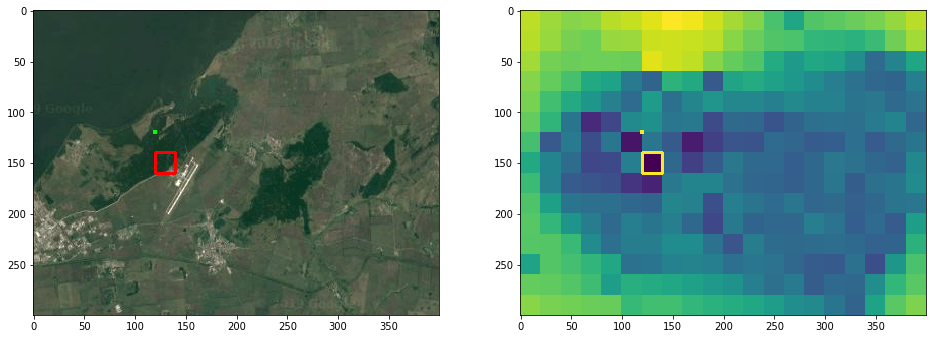

In [97]:
bigger_side = max(img_cutted_satellite.shape[0], img_cutted_satellite.shape[1])
one_block_len = bigger_side / bigger_side_blocks_count
print(one_block_len)
half = one_block_len / 2
print(half)

penalties_reshaped = np.array(penalties).reshape(int(len(penalties) / bigger_side_blocks_count),
                                                         bigger_side_blocks_count)
print(penalties_reshaped.shape)

img_result_show = img_cutted_satellite.copy()

for center_point in center_points_minimum_penalty:
    cv2.rectangle(img_result_show,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
img_result_show[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [[0, 255, 0] for _ in range(4)]

plt.figure(figsize=(16, 20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.subplot(122)

penalties_img = np.repeat(np.repeat(penalties_reshaped,
                                    one_block_len
                                    , axis=0),
                          one_block_len,
                          axis=1).reshape(img_result_show.shape[:2])
points_color = np.max(penalties)
for center_point in center_points_minimum_penalty:
    cv2.rectangle(penalties_img,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), points_color, 2)
penalties_img[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [points_color for _ in range(4)]
plt.imshow(penalties_img)

plt.show()

**Используем только 2 ближайших объекта**

In [98]:
agent_cd = cut_sectors(agent_cd, max_len=2)
agent_cd.make_fast()

In [99]:
%%time
center_points_minimum_penalty, indices_minimum_penalty, penalties = select_minimum_penalty_element_grid(img_cds,
                                                                                                        agent_cd,
                                                                                            use_fast=True)
print(center_points_minimum_penalty)
print(indices_minimum_penalty)

[(150.0, 130.0)]
[146]
CPU times: user 1min 29s, sys: 12 ms, total: 1min 29s
Wall time: 1min 29s


20.0
10.0
(15, 20)


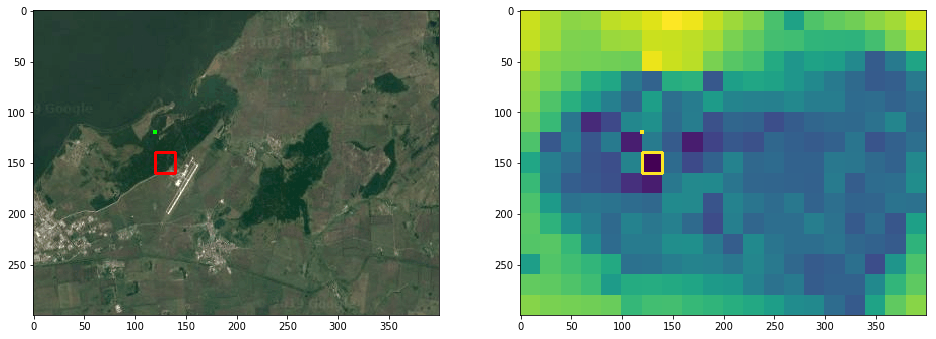

In [100]:
bigger_side = max(img_cutted_satellite.shape[0], img_cutted_satellite.shape[1])
one_block_len = bigger_side / bigger_side_blocks_count
print(one_block_len)
half = one_block_len / 2
print(half)

penalties_reshaped = np.array(penalties).reshape(int(len(penalties) / bigger_side_blocks_count),
                                                         bigger_side_blocks_count)
print(penalties_reshaped.shape)

img_result_show = img_cutted_satellite.copy()

for center_point in center_points_minimum_penalty:
    cv2.rectangle(img_result_show,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
img_result_show[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [[0, 255, 0] for _ in range(4)]

plt.figure(figsize=(16, 20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.subplot(122)

penalties_img = np.repeat(np.repeat(penalties_reshaped,
                                    one_block_len
                                    , axis=0),
                          one_block_len,
                          axis=1).reshape(img_result_show.shape[:2])
points_color = np.max(penalties)
for center_point in center_points_minimum_penalty:
    cv2.rectangle(penalties_img,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), points_color, 2)
penalties_img[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [points_color for _ in range(4)]
plt.imshow(penalties_img)

plt.show()

**Используем только 3 ближайших объекта**

In [101]:
agent_cd = cut_sectors(agent_cd, max_len=3)
agent_cd.make_fast()

In [102]:
%%time
center_points_minimum_penalty, indices_minimum_penalty, penalties = select_minimum_penalty_element_grid(img_cds,
                                                                                                        agent_cd,
                                                                                            use_fast=True)
print(center_points_minimum_penalty)
print(indices_minimum_penalty)

[(150.0, 130.0)]
[146]
CPU times: user 1min 29s, sys: 8 ms, total: 1min 29s
Wall time: 1min 29s


20.0
10.0
(15, 20)


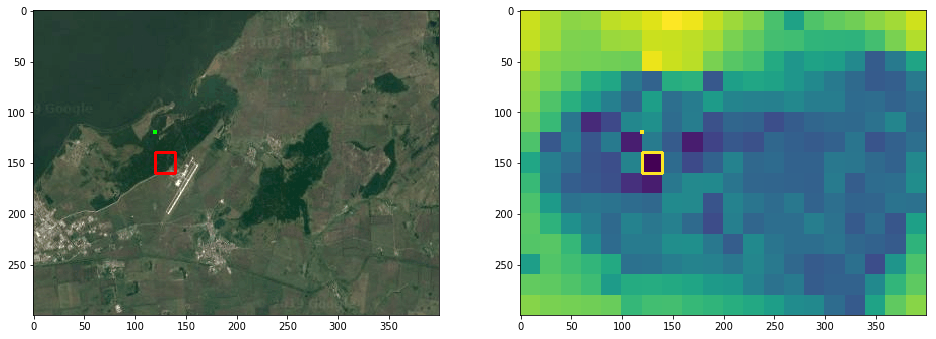

In [103]:
bigger_side = max(img_cutted_satellite.shape[0], img_cutted_satellite.shape[1])
one_block_len = bigger_side / bigger_side_blocks_count
print(one_block_len)
half = one_block_len / 2
print(half)

penalties_reshaped = np.array(penalties).reshape(int(len(penalties) / bigger_side_blocks_count),
                                                         bigger_side_blocks_count)
print(penalties_reshaped.shape)

img_result_show = img_cutted_satellite.copy()

for center_point in center_points_minimum_penalty:
    cv2.rectangle(img_result_show,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
img_result_show[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [[0, 255, 0] for _ in range(4)]

plt.figure(figsize=(16, 20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.subplot(122)

penalties_img = np.repeat(np.repeat(penalties_reshaped,
                                    one_block_len
                                    , axis=0),
                          one_block_len,
                          axis=1).reshape(img_result_show.shape[:2])
points_color = np.max(penalties)
for center_point in center_points_minimum_penalty:
    cv2.rectangle(penalties_img,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), points_color, 2)
penalties_img[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [points_color for _ in range(4)]
plt.imshow(penalties_img)

plt.show()

Как видно, на максимум 3х и максимум 2х объектах получаем примерно одинаковый результат, причём он также практически идентичен результату, получаемому на оригинальной диаграмме. 

Таким образом можно сделать вывод, что в целом результат не будет сильно хуже в реальных условиях, чем в идеальных, когда агенту якобу известны все возможные объекты.